<a href="https://colab.research.google.com/github/dannynew111/erp-clustering-smart-meter-data/blob/main/advanced_stats_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Setup and Load Data

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#I need lots of libraries for the advanced stats tests so best to import at start
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#  Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
pd.options.display.float_format = '{:.2f}'.format

#  Load the Report-Ready Dataset
# This is the clean output from your previous notebook
data_loaded_dir = '/content/drive/MyDrive/ERP/data_loaded/'
report_ready_path = os.path.join(data_loaded_dir, 'LCL_Report_Ready_Dataset.csv')
print("Loading the report-ready dataset...")
df = pd.read_csv(report_ready_path)

#  Define Persona Order and Colours for Consistency
persona_order = ['Contrarians', 'Engaged Shifters', 'Low-Volatility Consumers', 'Structurally Constrained']
df['persona_name'] = pd.Categorical(df['persona_name'], categories=persona_order, ordered=True)
persona_colours = {
    'Engaged Shifters': '#1f77b4',
    'Structurally Constrained': '#ff7f0e',
    'Contrarians': '#d62728',
    'Low-Volatility Consumers': '#9467bd'
}
print("Dataset loaded and prepared.")

Mounted at /content/drive
Loading the report-ready dataset...
Dataset loaded and prepared.


In [4]:
#  Feature Engineering - Create Composite Trait Scores
print("\n Creating composite trait scores ")

# A. Constraint Score = Measures perceived lifestyle rigidity
constraint_cols = [
    'Limited by Being Away From Home',
    'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines",
    'Limited by Fixed Household Habits'
]
df['trait_constraint_score'] = df[constraint_cols].mean(axis=1)
print("Created 'trait_constraint_score'.")

# B. Engagement Score = Measures positive attitude vs. focus on convenience
positive_attitude_cols = ['Felt More in Control of Bill', 'Planned Energy Use Around Tariffs', 'Desire to Remain on Tariff']
negative_attitude_cols = ['Prioritised Convenience', 'Perceived Inconvenience of Shifting']
df['trait_engagement_score'] = df[positive_attitude_cols].mean(axis=1) - df[negative_attitude_cols].mean(axis=1)
print("Created 'trait_engagement_score'.")



 Creating composite trait scores 
Created 'trait_constraint_score'.
Created 'trait_engagement_score'.



 Visualizing new trait scores 


/tmp/ipython-input-2802605960.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='persona_name', y='trait_constraint_score', data=df, palette=persona_colours, order=persona_order)
/tmp/ipython-input-2802605960.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='persona_name', y='trait_engagement_score', data=df, palette=persona_colours, order=persona_order)


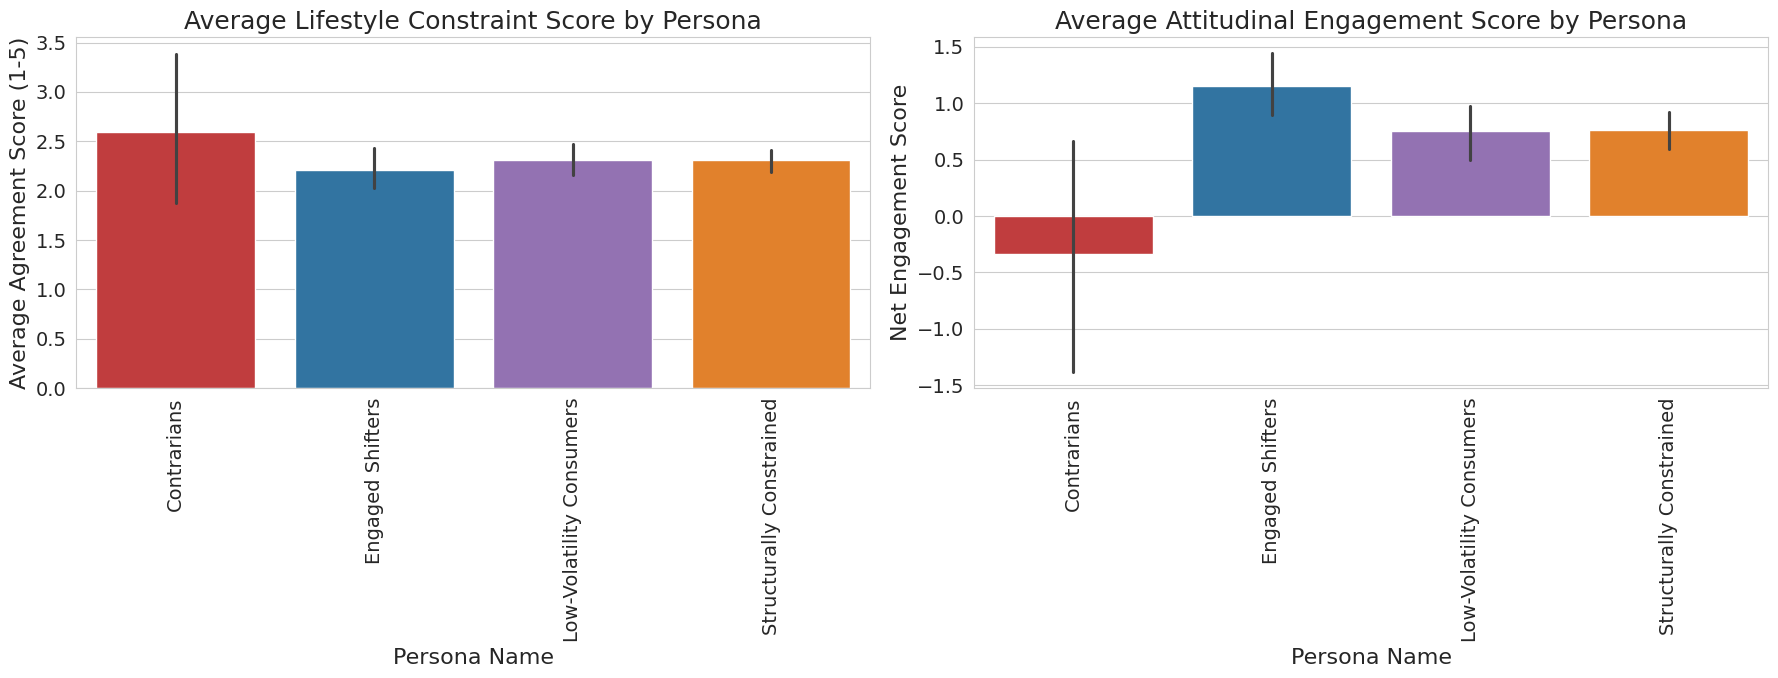

In [5]:
# Plotting Trait Scores by Persona
print("\n Visualizing new trait scores ")

plt.figure(figsize=(18, 7))

# Plot Constraint Score
plt.subplot(1, 2, 1)
sns.barplot(x='persona_name', y='trait_constraint_score', data=df, palette=persona_colours, order=persona_order)
plt.title('Average Lifestyle Constraint Score by Persona')
plt.ylabel('Average Agreement Score (1-5)')
plt.xlabel('Persona Name')
plt.xticks(rotation=90)

# Plot Engagement Score
plt.subplot(1, 2, 2)
sns.barplot(x='persona_name', y='trait_engagement_score', data=df, palette=persona_colours, order=persona_order)
plt.title('Average Attitudinal Engagement Score by Persona')
plt.ylabel('Net Engagement Score')
plt.xlabel('Persona Name')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



 Building a predictive model to identify drivers of behavior 
Feature set correctly created with 36 features.
The following columns were successfully excluded from the model:
['Household_id', 'persona', 'persona_name', 'peak_reduction_weekday', 'peak_reduction_pct_weekday', 'load_shift_weekday', 'peak_reduction_weekend', 'peak_reduction_pct_weekend', 'estimated_cost_savings_pct', 'economic_rationality_score', 'trial_weekday_high', 'trial_weekday_low', 'trial_weekday_normal', 'trial_weekend_high', 'trial_weekend_low', 'trial_weekend_normal']

Missing values before imputation in top 5 columns:
Has Fixed Routine for Tumble Dryer     791
Self-Reported Shift of Tumble Dryer    768
Has Fixed Routine for Dishwasher       767
Self-Reported Shift of Dishwasher      738
Limited by Inflexible Work Schedule    568
dtype: int64

Missing values handled via median imputation.


/tmp/ipython-input-1564295276.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)



Model Accuracy on Test Set: 55.52%
Model OOB (Out-of-Bag) Score: 59.55%

 Generating CORRECTED feature importance plot 


/tmp/ipython-input-1564295276.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index, palette='viridis')


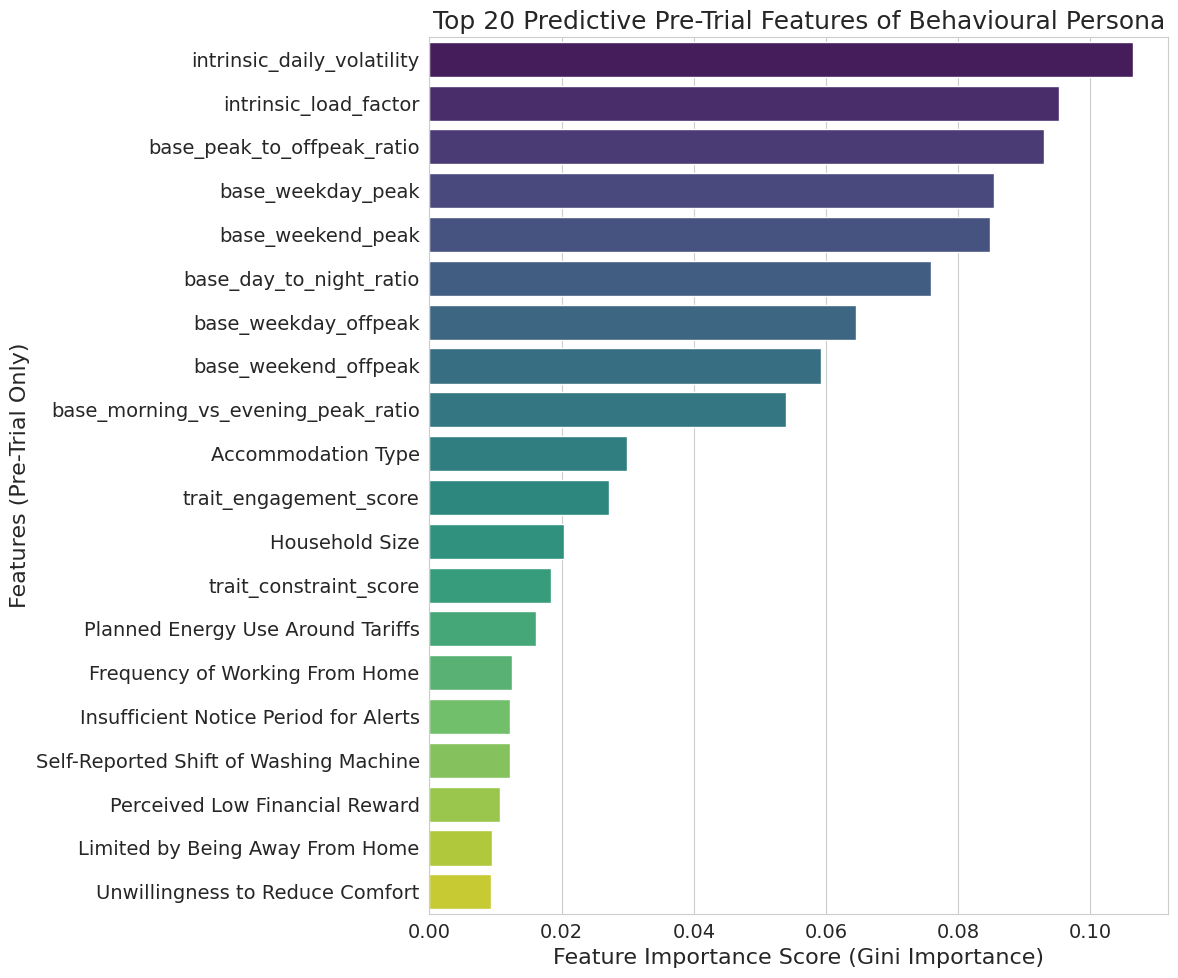

In [6]:
#  Predictive Modeling to Find Key Drivers - KEY VALIDATION for my report!!
print("\n Building a predictive model to identify drivers of behavior ")

#  Prepare data for the model

# A. Define ALL columns that represent TRIAL OUTCOMES or should not be features
# This list is now comprehensive, including the target itself and all profiling/responsiveness columns
columns_to_exclude = [
    #  Identifiers and Targets
    'Household_id',
    'persona', # The target variable itself
    'persona_name',

    #  Responsiveness Features (Trial Outcomes)
    'peak_reduction_weekday',
    'peak_reduction_pct_weekday',
    'load_shift_weekday',
    'peak_reduction_weekend',
    'peak_reduction_pct_weekend',

    #  Financial Features (Trial Outcomes)
    'estimated_cost_savings_pct',
    'economic_rationality_score',
    #  Trial Period Consumption Features (From Profiling Tables)
    'trial_weekday_high',
    'trial_weekday_low',
    'trial_weekday_normal',
    'trial_weekend_high',
    'trial_weekend_low',
    'trial_weekend_normal'

]

# B. Define the target variable (y) and the feature set (X)
y = df['persona_name']

# The feature set X is the original dataframe minus all excluded columns
X = df.drop(columns=columns_to_exclude, errors='ignore').copy()

print(f"Feature set correctly created with {X.shape[1]} features.")
print("The following columns were successfully excluded from the model:")
print([col for col in columns_to_exclude if col in df.columns]) # Show which ones were actually found and dropped


# C. Handle missing values in the feature set before modeling
print(f"\nMissing values before imputation in top 5 columns:\n{X.isnull().sum().sort_values(ascending=False).head()}")
for col in X.columns:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)
print("\nMissing values handled via median imputation.")


#  Train the Random Forest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
model = RandomForestClassifier(n_estimators=150, random_state=42, oob_score=True, class_weight='balanced')
model.fit(X_train, y_train)

#  Evaluate Model Performance
print(f"\nModel Accuracy on Test Set: {accuracy_score(y_test, model.predict(X_test)):.2%}")
print(f"Model OOB (Out-of-Bag) Score: {model.oob_score_:.2%}") # This is a very reliable accuracy estimate


#  Feature Importance Plot - this will go in y report
print("\n Generating CORRECTED feature importance plot ")
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index, palette='viridis')
plt.title('Top 20 Predictive Pre-Trial Features of Behavioural Persona')
plt.xlabel('Feature Importance Score (Gini Importance)')
plt.ylabel('Features (Pre-Trial Only)')
plt.tight_layout()
plt.show()


Generating the Quadrant plot


/tmp/ipython-input-2150387707.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()


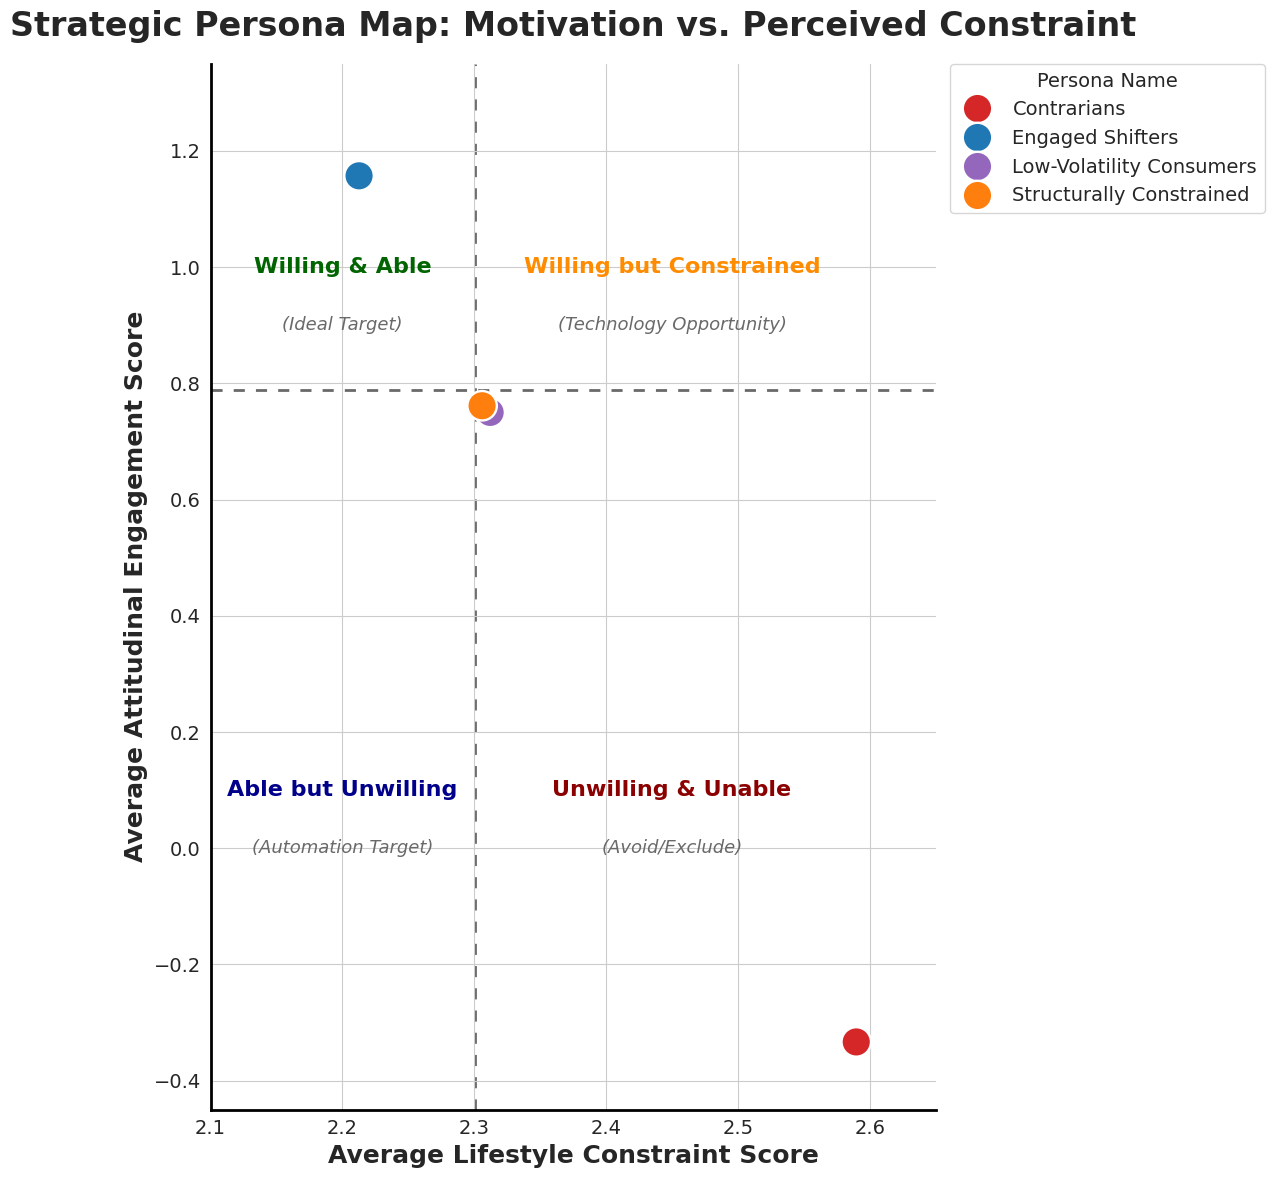

In [7]:
# Persona Motivation/Constraint Visualisation - key to my project

print("\nGenerating the Quadrant plot")

#  A. Prepare the data points
df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()
avg_constraint = df['trait_constraint_score'].mean()
avg_engagement = df['trait_engagement_score'].mean()

#  B. Create the plot and get the axes object for customisation
fig, ax = plt.subplots(figsize=(14, 12))
sns.set_style("whitegrid")

# Create the scatter plot
sns.scatterplot(
    x='trait_constraint_score',
    y='trait_engagement_score',
    data=df_persona_traits,
    hue='persona_name',
    hue_order=persona_order,
    palette=persona_colours,
    s=450,
    legend='full',
    ax=ax, # Pass the axes object here
    zorder=10
)

#  C. Customize Legend
ax.legend(
    title='Persona Name', title_fontsize='14', bbox_to_anchor=(1.02, 1),
    loc='upper left', borderaxespad=0., fontsize='14'
)

#  D. Add Quadrant Divider Lines
ax.axhline(avg_engagement, color='dimgray', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)
ax.axvline(avg_constraint, color='dimgray', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)

#  E. Add Polished Quadrant Labels
quadrant_title_props = dict(fontsize=16, weight='bold', ha='center', va='center')
quadrant_subtitle_props = dict(fontsize=13, style='italic', ha='center', va='center', color='dimgray')

ax.text(2.20, 1.0, 'Willing & Able', color='darkgreen', **quadrant_title_props)
ax.text(2.20, 0.9, '(Ideal Target)', **quadrant_subtitle_props)
ax.text(2.45, 1.0, 'Willing but Constrained', color='darkorange', **quadrant_title_props)
ax.text(2.45, 0.9, '(Technology Opportunity)', **quadrant_subtitle_props)
ax.text(2.20, 0.1, 'Able but Unwilling', color='darkblue', **quadrant_title_props)
ax.text(2.20, 0.0, '(Automation Target)', **quadrant_subtitle_props)
ax.text(2.45, 0.1, 'Unwilling & Unable', color='darkred', **quadrant_title_props)
ax.text(2.45, 0.0, '(Avoid/Exclude)', **quadrant_subtitle_props)

#  F. Final Styling: Titles and Formal Axis Labels
ax.set_title('Strategic Persona Map: Motivation vs. Perceived Constraint', fontsize=24, weight='bold', pad=20)
ax.set_xlabel('Average Lifestyle Constraint Score', fontsize=18, weight='bold')
ax.set_ylabel('Average Attitudinal Engagement Score', fontsize=18, weight='bold')

# Make the bottom and left axis spines bold and black
ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
# Hide the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#  G. Manually set axis limits and ticks
ax.set_xlim(2.10, 2.65)
ax.set_ylim(-0.45, 1.35)
ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for the legend
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()

/tmp/ipython-input-2249357268.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()


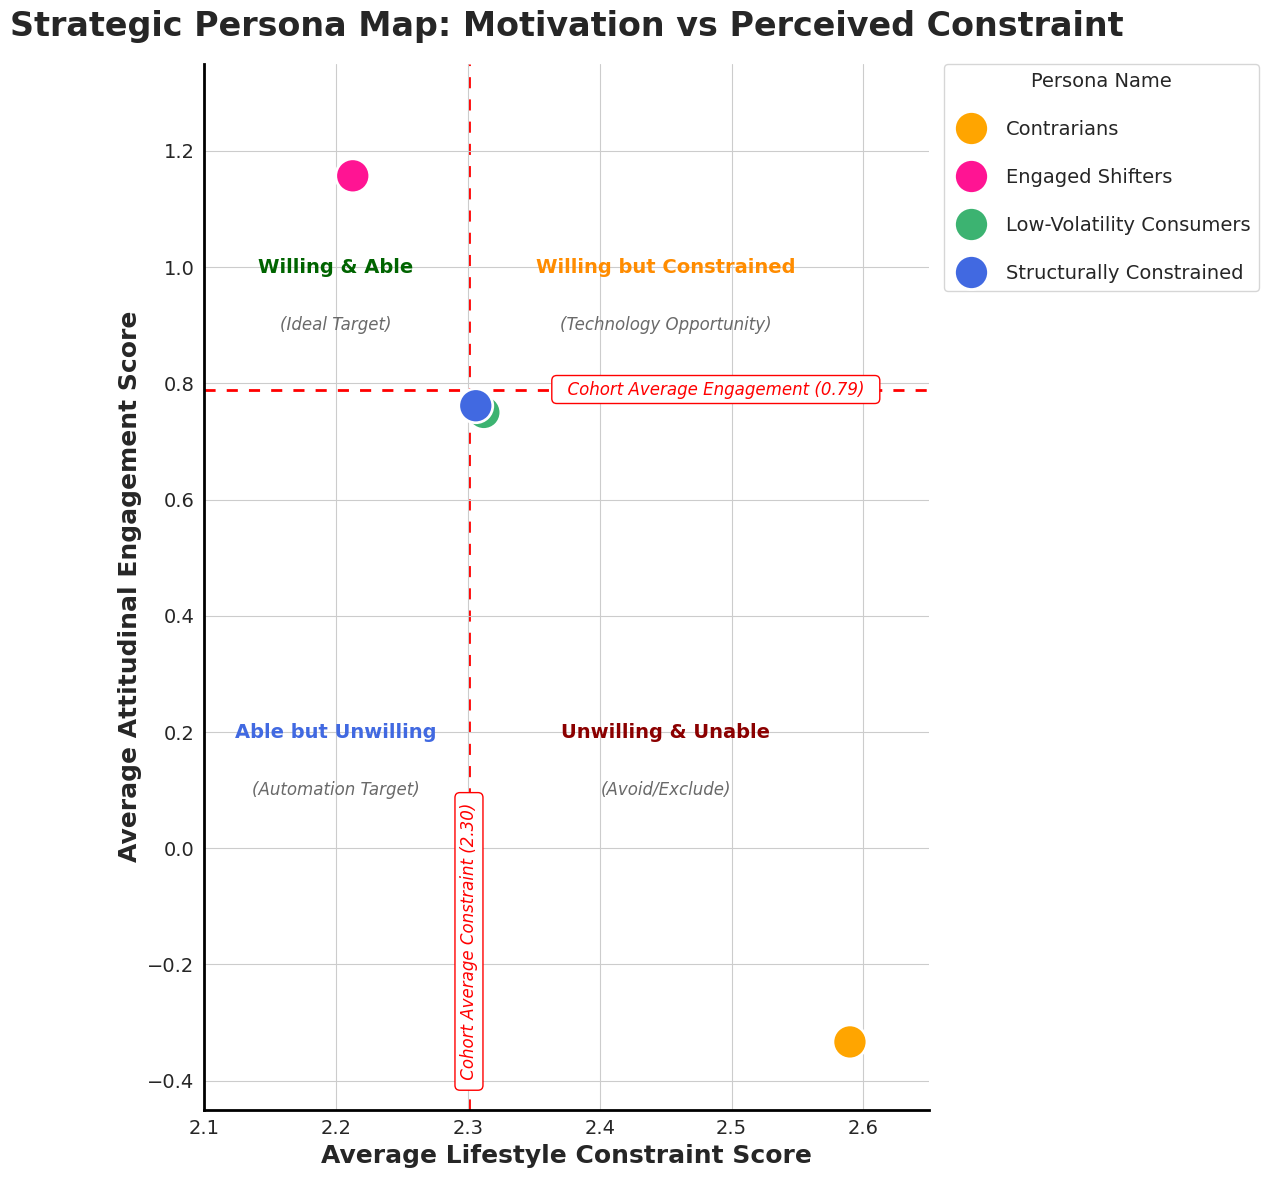

In [8]:
#The NOVEL strategic persona map - crucial to my interpretation

#  A. Prepare the data points
df_persona_traits = df.groupby('persona_name')[['trait_constraint_score', 'trait_engagement_score']].mean().reset_index()
avg_constraint = df['trait_constraint_score'].mean()
avg_engagement = df['trait_engagement_score'].mean()

#  Define the colour palette
strategic_palette = {
    'Engaged Shifters': 'deeppink',
    'Contrarians': 'orange',
    'Low-Volatility Consumers': 'mediumseagreen',
    'Structurally Constrained': 'royalblue'
}

#  B. Create the plot and get the axes object for customization
fig, ax = plt.subplots(figsize=(14, 12))
sns.set_style("whitegrid")

# Create the scatter plot
sns.scatterplot(
    x='trait_constraint_score',
    y='trait_engagement_score',
    data=df_persona_traits,
    hue='persona_name',
    hue_order=persona_order,
    palette=strategic_palette,
    s=600,
    legend='full',
    ax=ax,
    zorder=10
)

#  C. Customise Legend
legend = ax.legend(
    title='Persona Name', title_fontsize='14', bbox_to_anchor=(1.02, 1),
    loc='upper left', borderaxespad=0., fontsize='14',
    labelspacing=1.5
)

#  D. Add Quadrant Divider Lines - key for separating personas
ax.axhline(avg_engagement, color='red', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)
ax.axvline(avg_constraint, color='red', linestyle='--', linewidth=2, dashes=(4, 4), zorder=0)

bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1)
ax.text(ax.get_xlim()[1], avg_engagement, f'  Cohort Average Engagement ({avg_engagement:.2f})  ',
        ha='right', va='center', fontsize=12, style='italic', color='red',
        bbox=bbox_props)
ax.text(avg_constraint, ax.get_ylim()[0], f' Cohort Average Constraint ({avg_constraint:.2f}) ',
        ha='center', va='bottom', fontsize=12, style='italic', color='red',
        bbox=bbox_props, rotation=90)

#  E. Add Polished Quadrant Labels
quadrant_title_props = dict(fontsize=14, weight='bold', ha='center', va='center')
quadrant_subtitle_props = dict(fontsize=12, style='italic', ha='center', va='center', color='dimgray')

ax.text(2.45, 1.0, 'Willing but Constrained', color='darkorange', **quadrant_title_props)
ax.text(2.45, 0.90, '(Technology Opportunity)', **quadrant_subtitle_props)

ax.text(2.20, 1.0, 'Willing & Able', color='darkgreen', **quadrant_title_props)
ax.text(2.20, 0.90, '(Ideal Target)', **quadrant_subtitle_props)

ax.text(2.20, 0.2, 'Able but Unwilling', color='royalblue', **quadrant_title_props)
ax.text(2.20, 0.1, '(Automation Target)', **quadrant_subtitle_props)

ax.text(2.45, 0.2, 'Unwilling & Unable', color='darkred', **quadrant_title_props)
ax.text(2.45, 0.1, '(Avoid/Exclude)', **quadrant_subtitle_props)

#  F. Final Styling: Titles and Formal Axis Labels
ax.set_title('Strategic Persona Map: Motivation vs Perceived Constraint', fontsize=24, weight='bold', pad=20)
ax.set_xlabel('Average Lifestyle Constraint Score', fontsize=18, weight='bold')
ax.set_ylabel('Average Attitudinal Engagement Score', fontsize=18, weight='bold')


ax.spines['bottom'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#  Manually set axis limits and ticks
ax.set_xlim(2.10, 2.65)
ax.set_ylim(-0.45, 1.35)
ax.tick_params(axis='both', which='major', labelsize=14)

# Adjust layout to make space for the legend
fig.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


Generating Demographic Profile plots


/tmp/ipython-input-1974795743.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


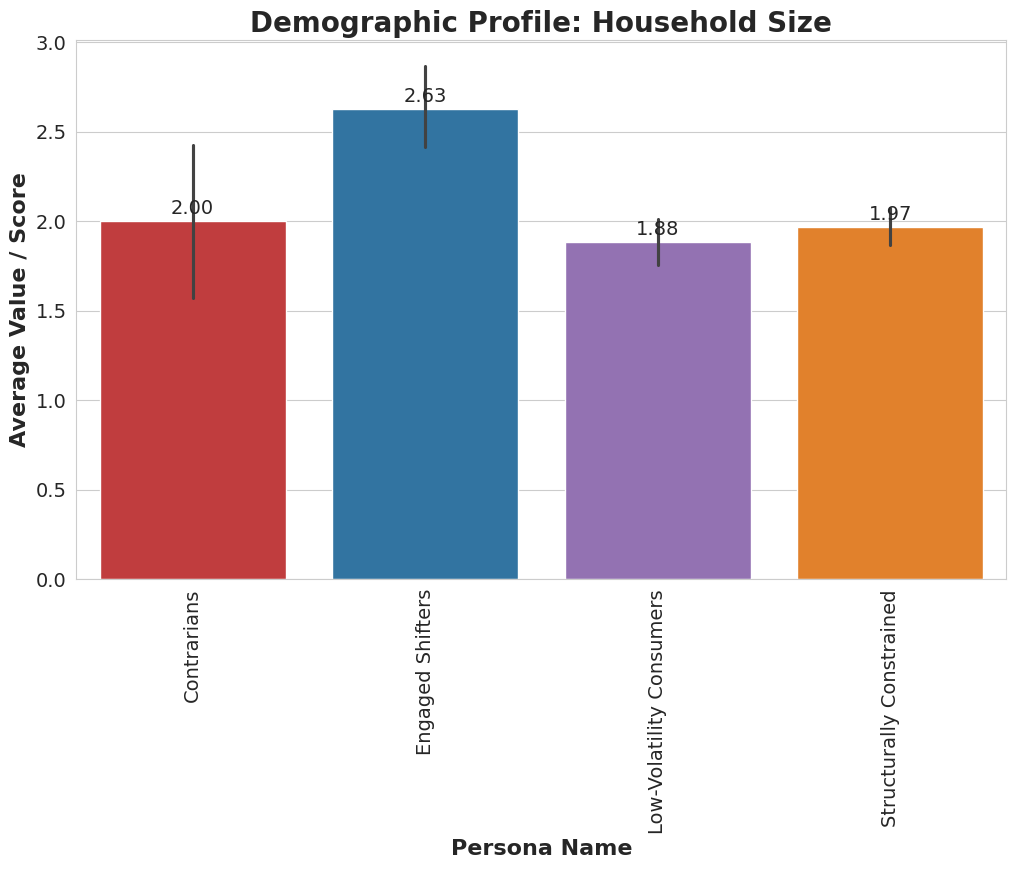

/tmp/ipython-input-1974795743.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


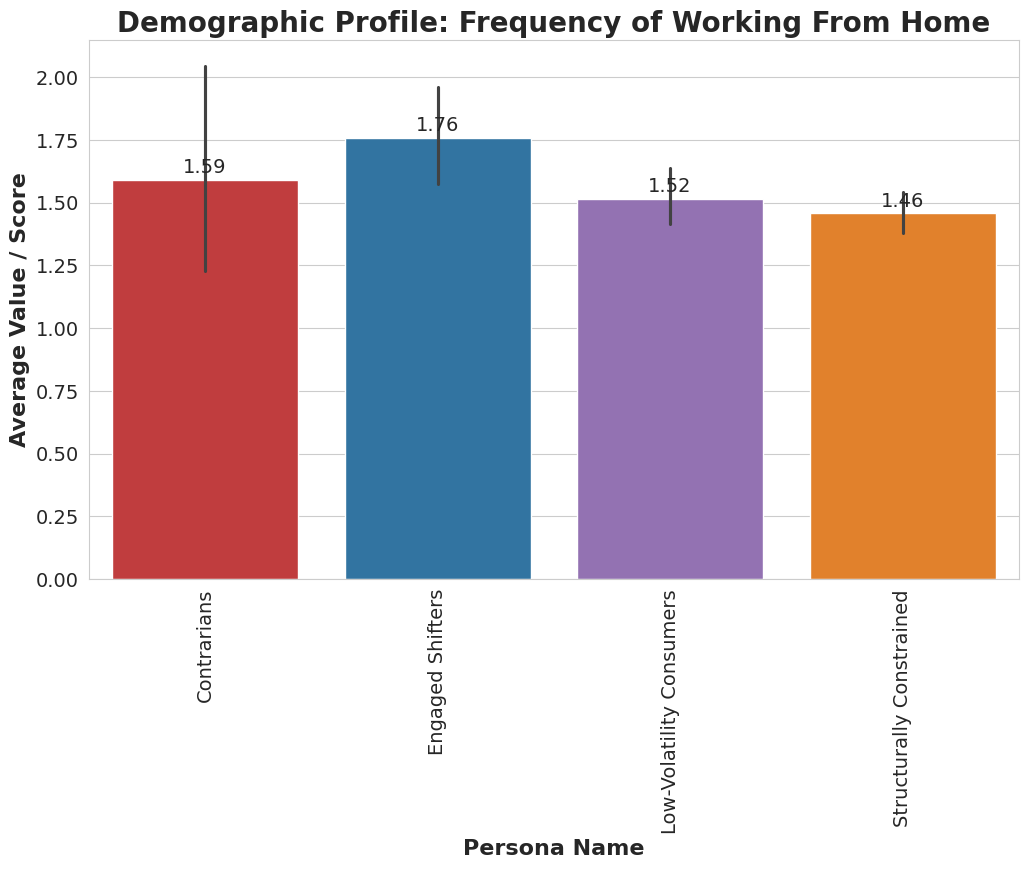

/tmp/ipython-input-1974795743.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


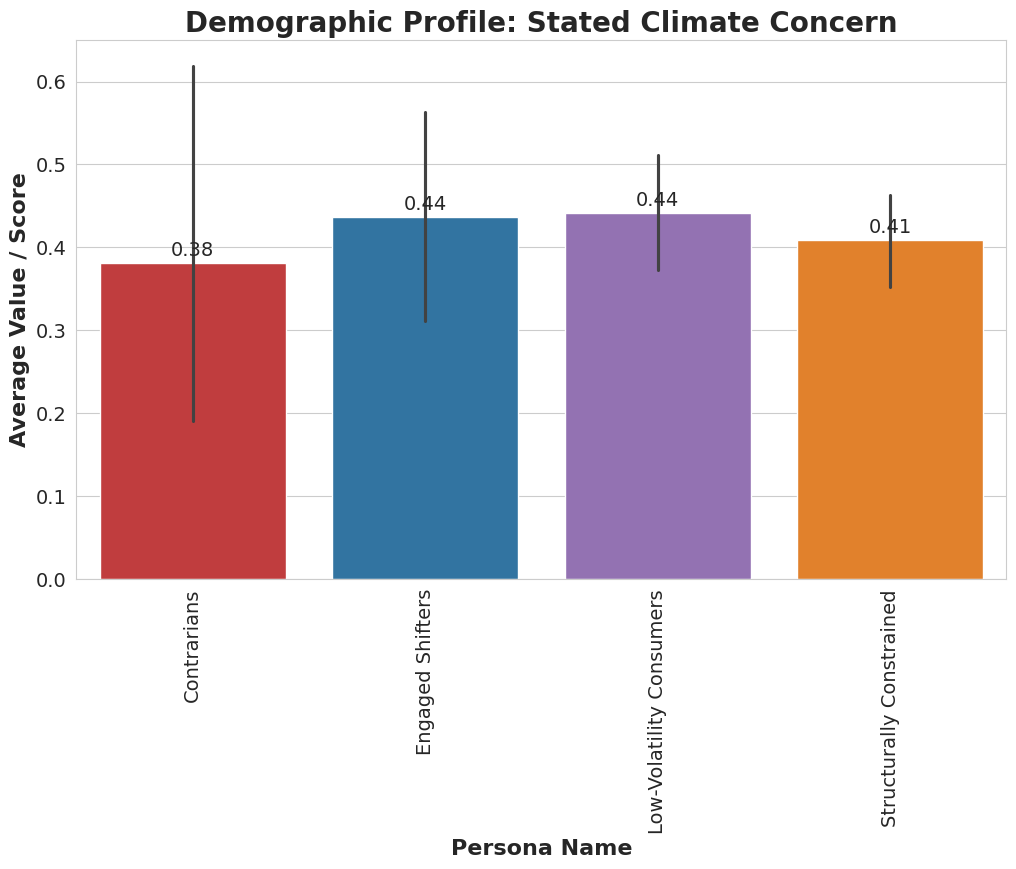

/tmp/ipython-input-1974795743.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


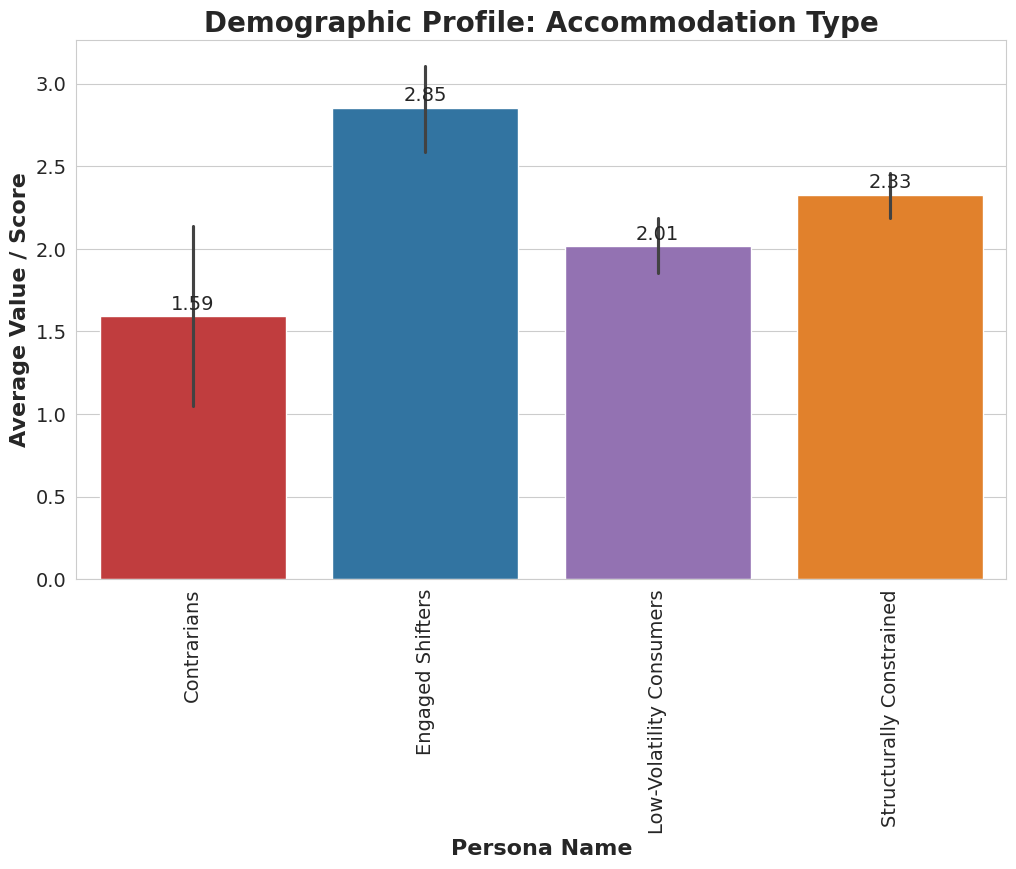

In [9]:
# Specific persona characteristics
# This section creates detailed plots for individual features to add texture
# and concrete evidence to the persona narratives.


#  Set a consistent plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# Demographic profiles
print("\nGenerating Demographic Profile plots")

demographic_features = {
    'Household Size': 'Household Size',
    'Frequency of Working From Home': 'Frequency of Working From Home',
    'Stated Climate Concern': 'Stated Climate Concern',
    'Accommodation Type': 'Accommodation Type'
}

for col, title in demographic_features.items():
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)
    ax.set_title(f'Demographic Profile: {title}', weight='bold')
    ax.set_xlabel('Persona Name', weight='bold')
    ax.set_ylabel('Average Value / Score', weight='bold')
    plt.xticks(rotation=90)

    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')
    plt.show()


Generating Perceived Barriers Heatmap


/tmp/ipython-input-3172796870.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  barrier_data = df.groupby('persona_name')[barrier_cols].mean().reindex(persona_order)


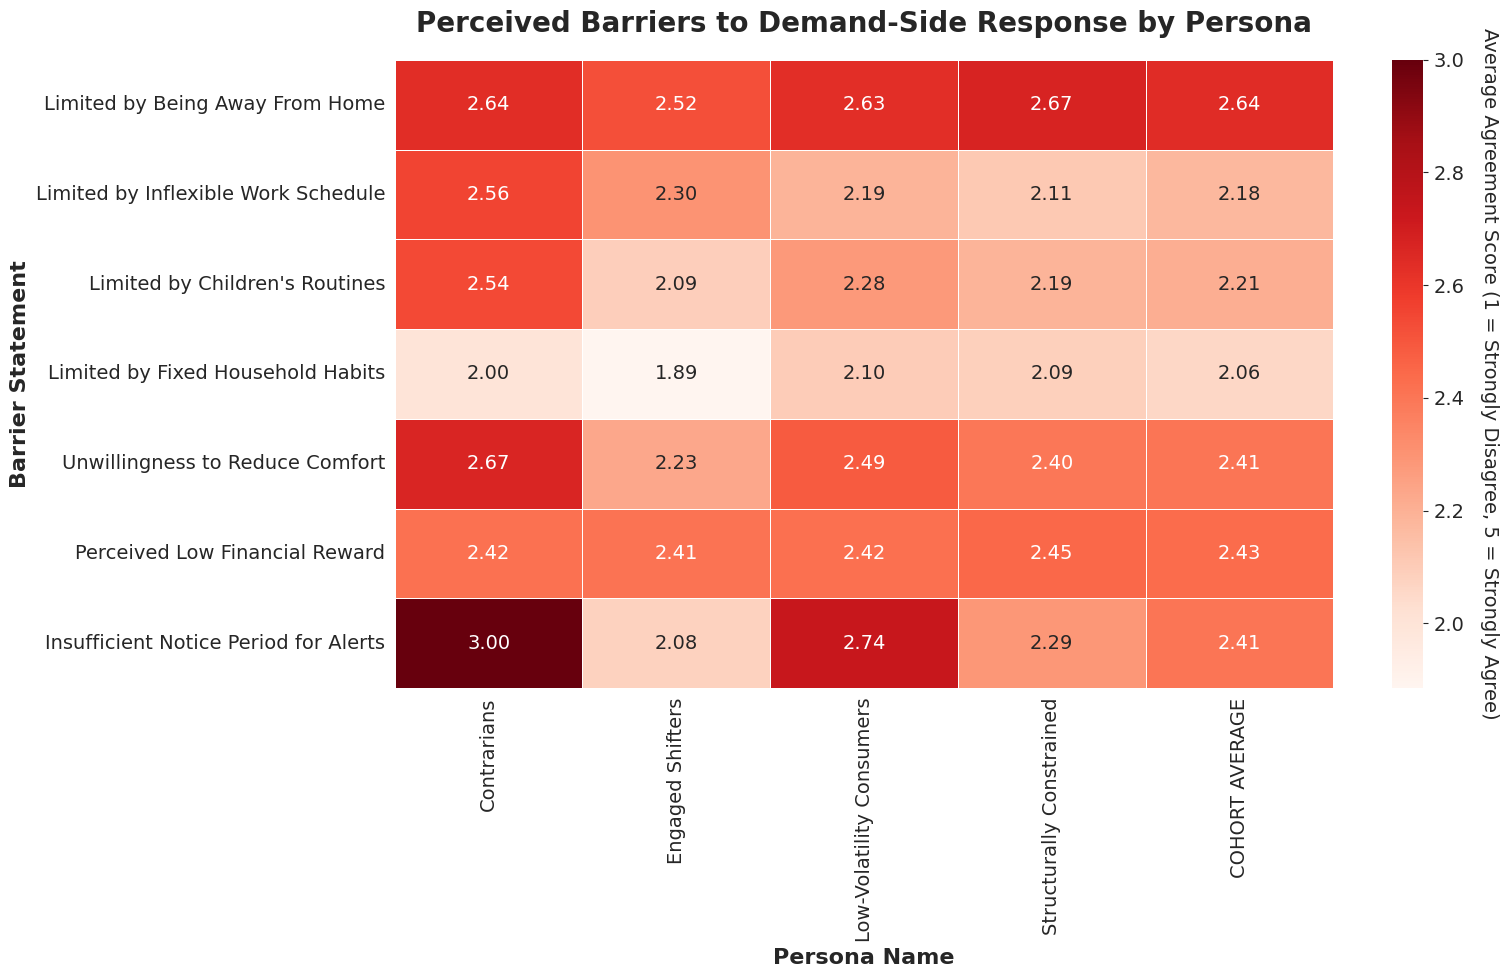

In [10]:
# Barrier analysis heatmap

print("\nGenerating Perceived Barriers Heatmap")

barrier_cols = [
    'Limited by Being Away From Home', 'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines", 'Limited by Fixed Household Habits',
    'Unwillingness to Reduce Comfort', 'Perceived Low Financial Reward',
    'Insufficient Notice Period for Alerts'
]

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(16, 10))

# Calculate the average agreement score for each barrier by persona
barrier_data = df.groupby('persona_name')[barrier_cols].mean().reindex(persona_order)
barrier_data.loc['COHORT AVERAGE'] = df[barrier_cols].mean()

heatmap = sns.heatmap(
    barrier_data.T,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    linewidths=.5,
    ax=ax
)

#  Manually adjust colour bar label as wasn't fitting on screen before
cbar = heatmap.collections[0].colorbar
cbar.set_label(
    'Average Agreement Score (1 = Strongly Disagree, 5 = Strongly Agree)',
    rotation=270, # Rotate the label to be horizontal
    labelpad=25,   # Move the label further away from the color bar
    fontsize=14    # adjusted font size
)


ax.set_title('Perceived Barriers to Demand-Side Response by Persona', weight='bold', pad=20, fontsize=20)
ax.set_xlabel('Persona Name', weight='bold', fontsize=16)
ax.set_ylabel('Barrier Statement', weight='bold', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(rotation=0, fontsize=14)

# Use tight_layout as a final polish, now that the main issue is solved
plt.tight_layout()
plt.show()


Generating Attitude Comparison plots


/tmp/ipython-input-483764831.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
/tmp/ipython-input-483764831.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(


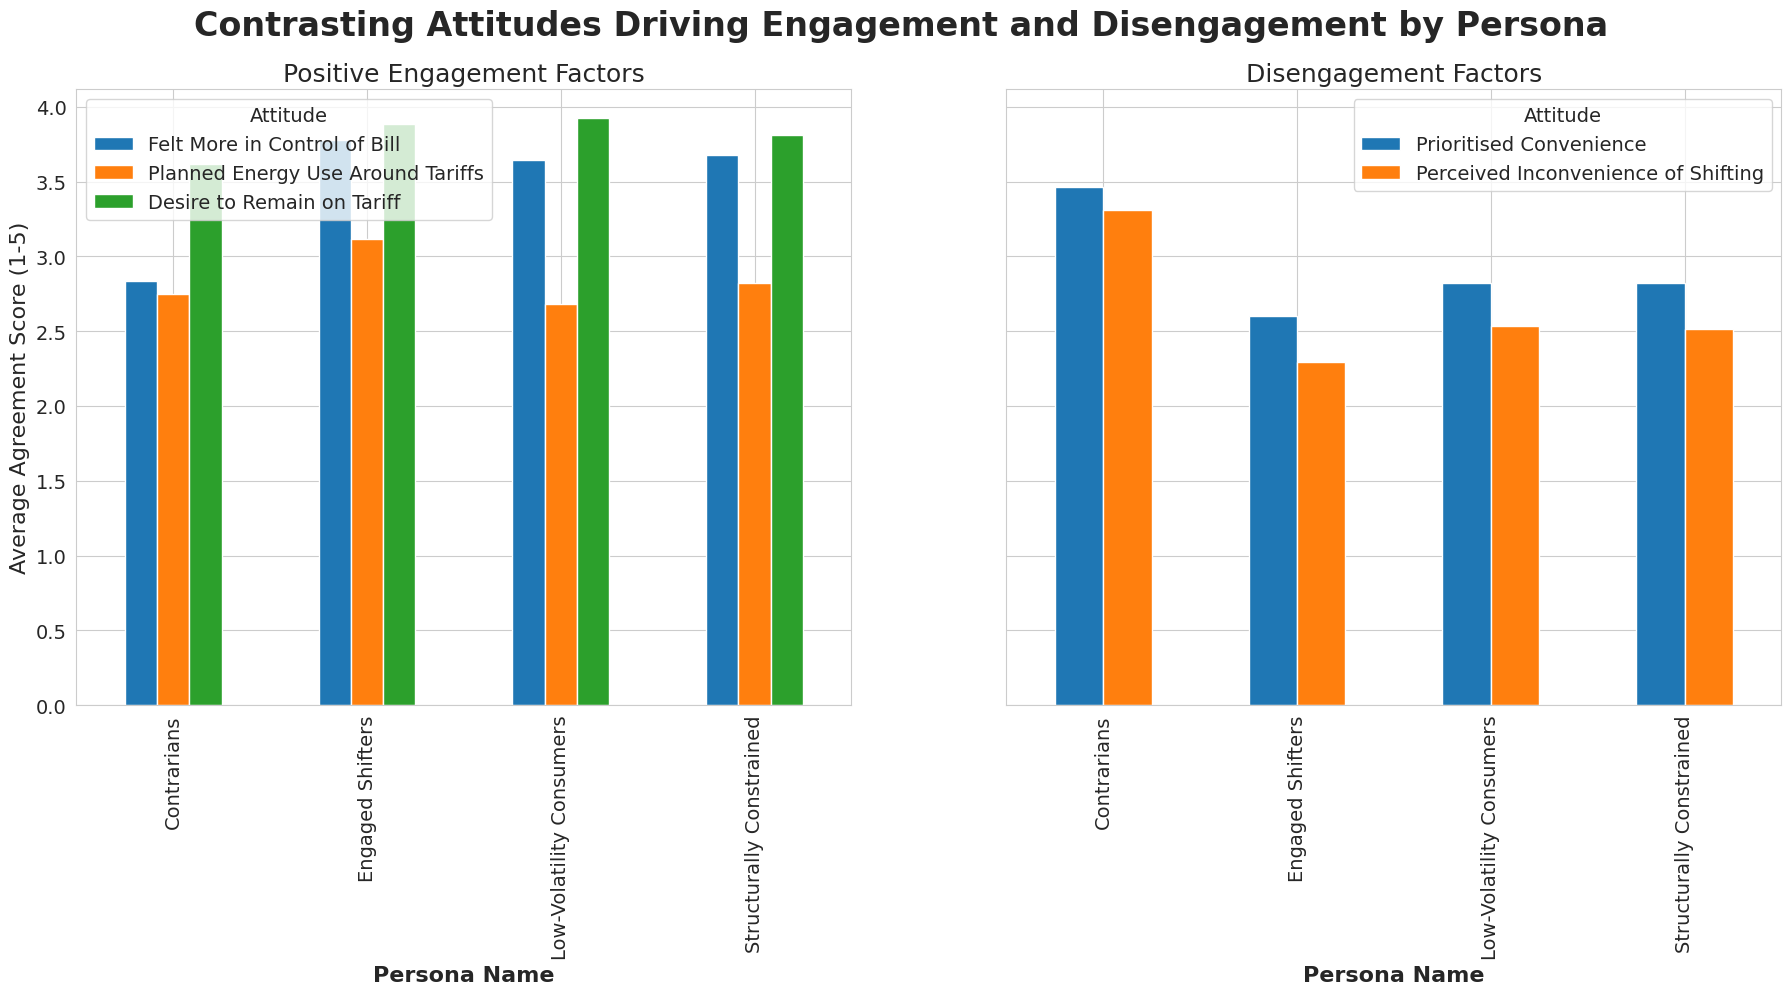

In [11]:
# Attitude comparison
print("\nGenerating Attitude Comparison plots")

# Define Positive vs. Disengagement factors
positive_factors = {
    'Felt More in Control of Bill': 'Felt More in Control of Bill',
    'Planned Energy Use Around Tariffs': 'Planned Energy Use Around Tariffs',
    'Desire to Remain on Tariff': 'Desire to Remain on Tariff'
}
disengagement_factors = {
    'Prioritised Convenience': 'Prioritised Convenience',
    'Perceived Inconvenience of Shifting': 'Perceived Inconvenience of Shifting'
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=True)
fig.suptitle('Contrasting Attitudes Driving Engagement and Disengagement by Persona', fontsize=24, weight='bold')

# Plot Positive Engagement Factors
df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
axes[0].set_title('Positive Engagement Factors', fontsize=18)
axes[0].set_ylabel('Average Agreement Score (1-5)')
axes[0].set_xlabel('Persona Name', weight='bold')
axes[0].legend(title='Attitude')
axes[0].tick_params(axis='x', rotation=90)

# Plot Disengagement Factors
df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e']
)
axes[1].set_title('Disengagement Factors', fontsize=18)
axes[1].set_xlabel('Persona Name', weight='bold')
axes[1].legend(title='Attitude')
axes[1].tick_params(axis='x', rotation=90)

plt.show()


[3] Generating Attitude Comparison plots...


/tmp/ipython-input-1230192281.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
/tmp/ipython-input-1230192281.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(


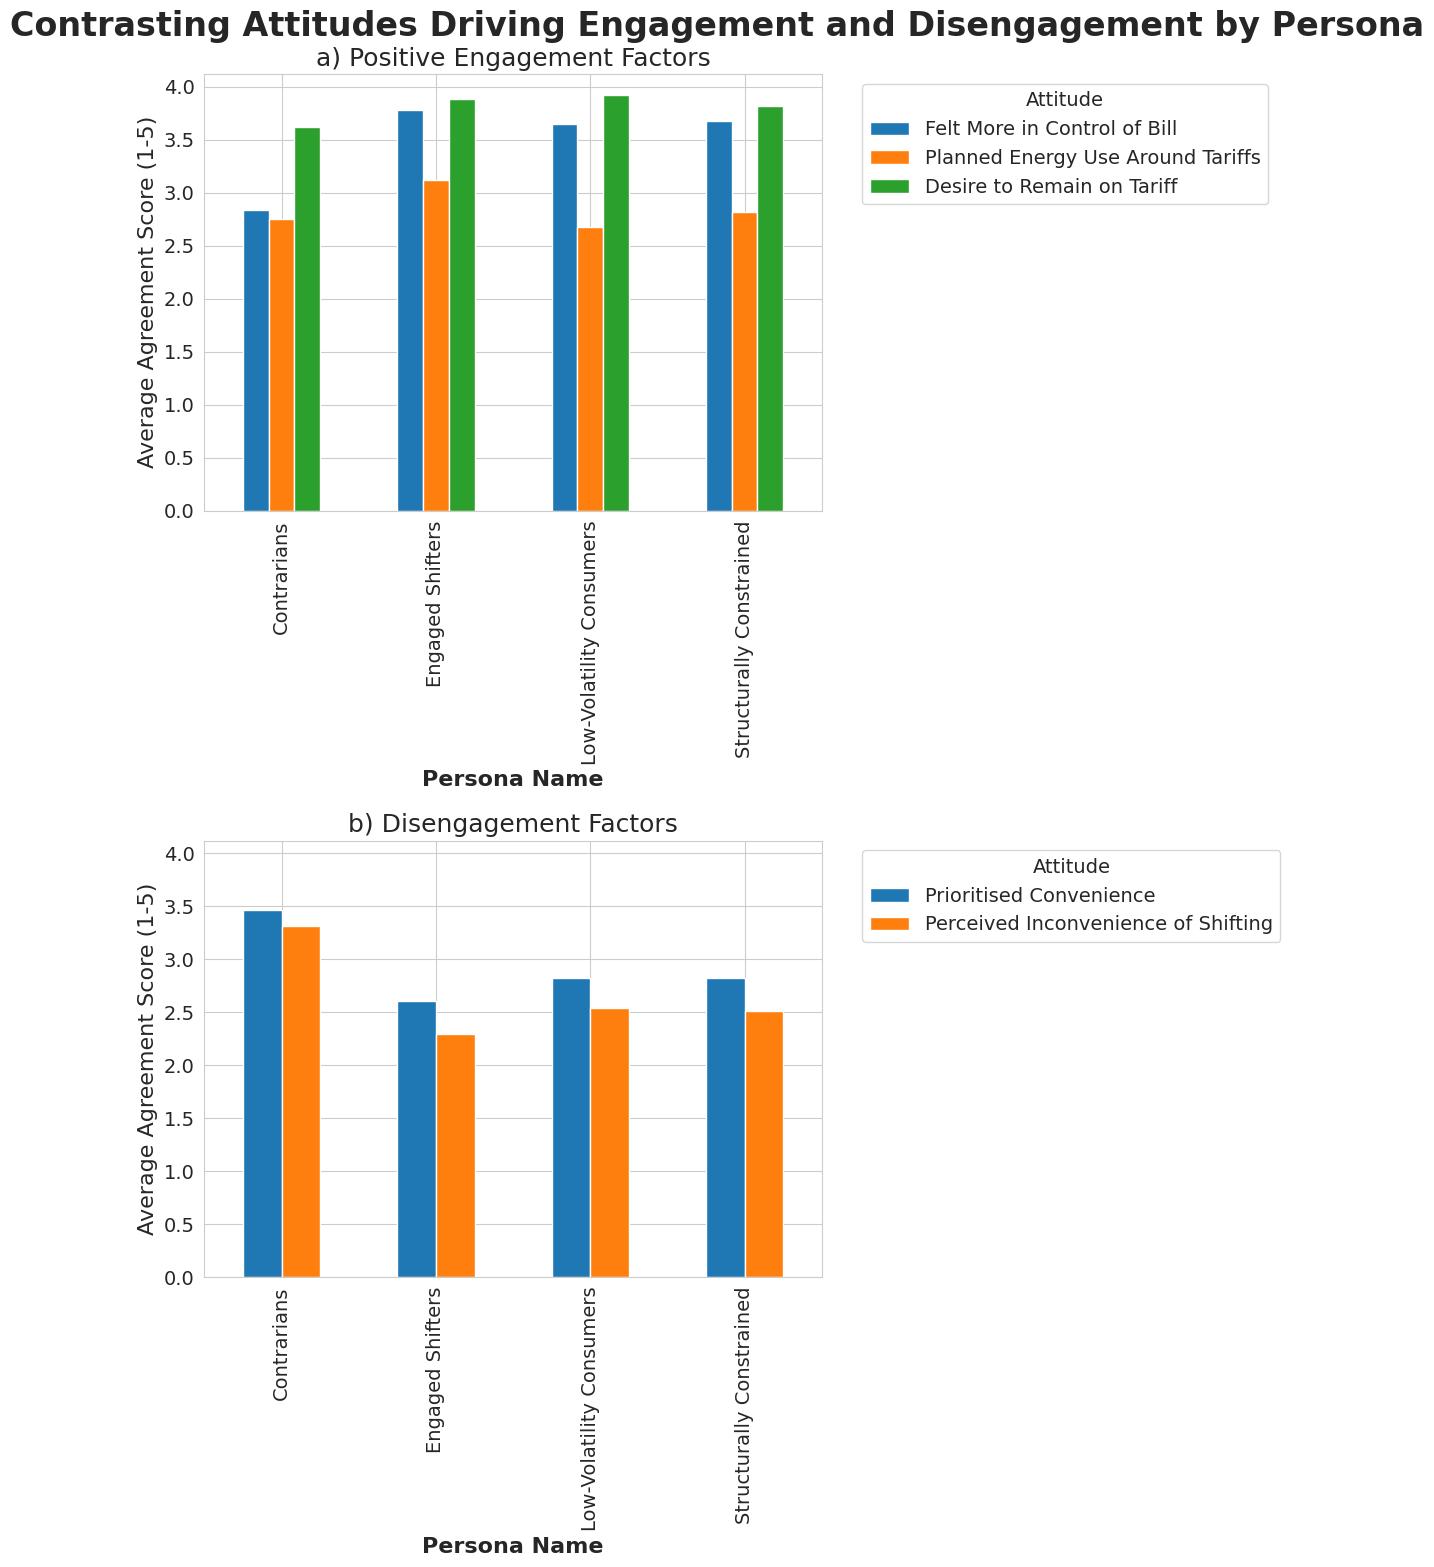

In [13]:
# different visual with one on top of other in case fits better in report
print("\n[3] Generating Attitude Comparison plots...")

# Define Positive vs. Disengagement factors
positive_factors = {
    'Felt More in Control of Bill': 'Felt More in Control of Bill',
    'Planned Energy Use Around Tariffs': 'Planned Energy Use Around Tariffs',
    'Desire to Remain on Tariff': 'Desire to Remain on Tariff'
}
disengagement_factors = {
    'Prioritised Convenience': 'Prioritised Convenience',
    'Perceived Inconvenience of Shifting': 'Perceived Inconvenience of Shifting'
}

# On top of other instead of side by side
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
fig.suptitle('Contrasting Attitudes Driving Engagement and Disengagement by Persona', fontsize=24, weight='bold')

# Plot Positive Engagement Factors
df.groupby('persona_name')[list(positive_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c']
)
axes[0].set_title('a) Positive Engagement Factors', fontsize=18)
axes[0].set_ylabel('Average Agreement Score (1-5)')
axes[0].set_xlabel('Persona Name', weight='bold')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='Attitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Disengagement Factors
df.groupby('persona_name')[list(disengagement_factors.keys())].mean().reindex(persona_order).plot(
    kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e']
)
axes[1].set_title('b) Disengagement Factors', fontsize=18)
axes[1].set_ylabel('Average Agreement Score (1-5)')
axes[1].set_xlabel('Persona Name', weight='bold')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='Attitude', bbox_to_anchor=(1.05, 1), loc='upper left')

# Match y-axis limits manually
ymin = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(ymin, ymax)
axes[1].set_ylim(ymin, ymax)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.94) # Adjust top margin for the main title

plt.show()


Generating Appliance Shifting vs. Routine Rigidity plots...


/tmp/ipython-input-3590354030.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shift_data = df.groupby('persona_name')[shift_col].mean().reindex(persona_order)
/tmp/ipython-input-3590354030.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  routine_data = df.groupby('persona_name')[routine_col].mean().reindex(persona_order) * 100 # as percentage
/tmp/ipython-input-3590354030.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence thi

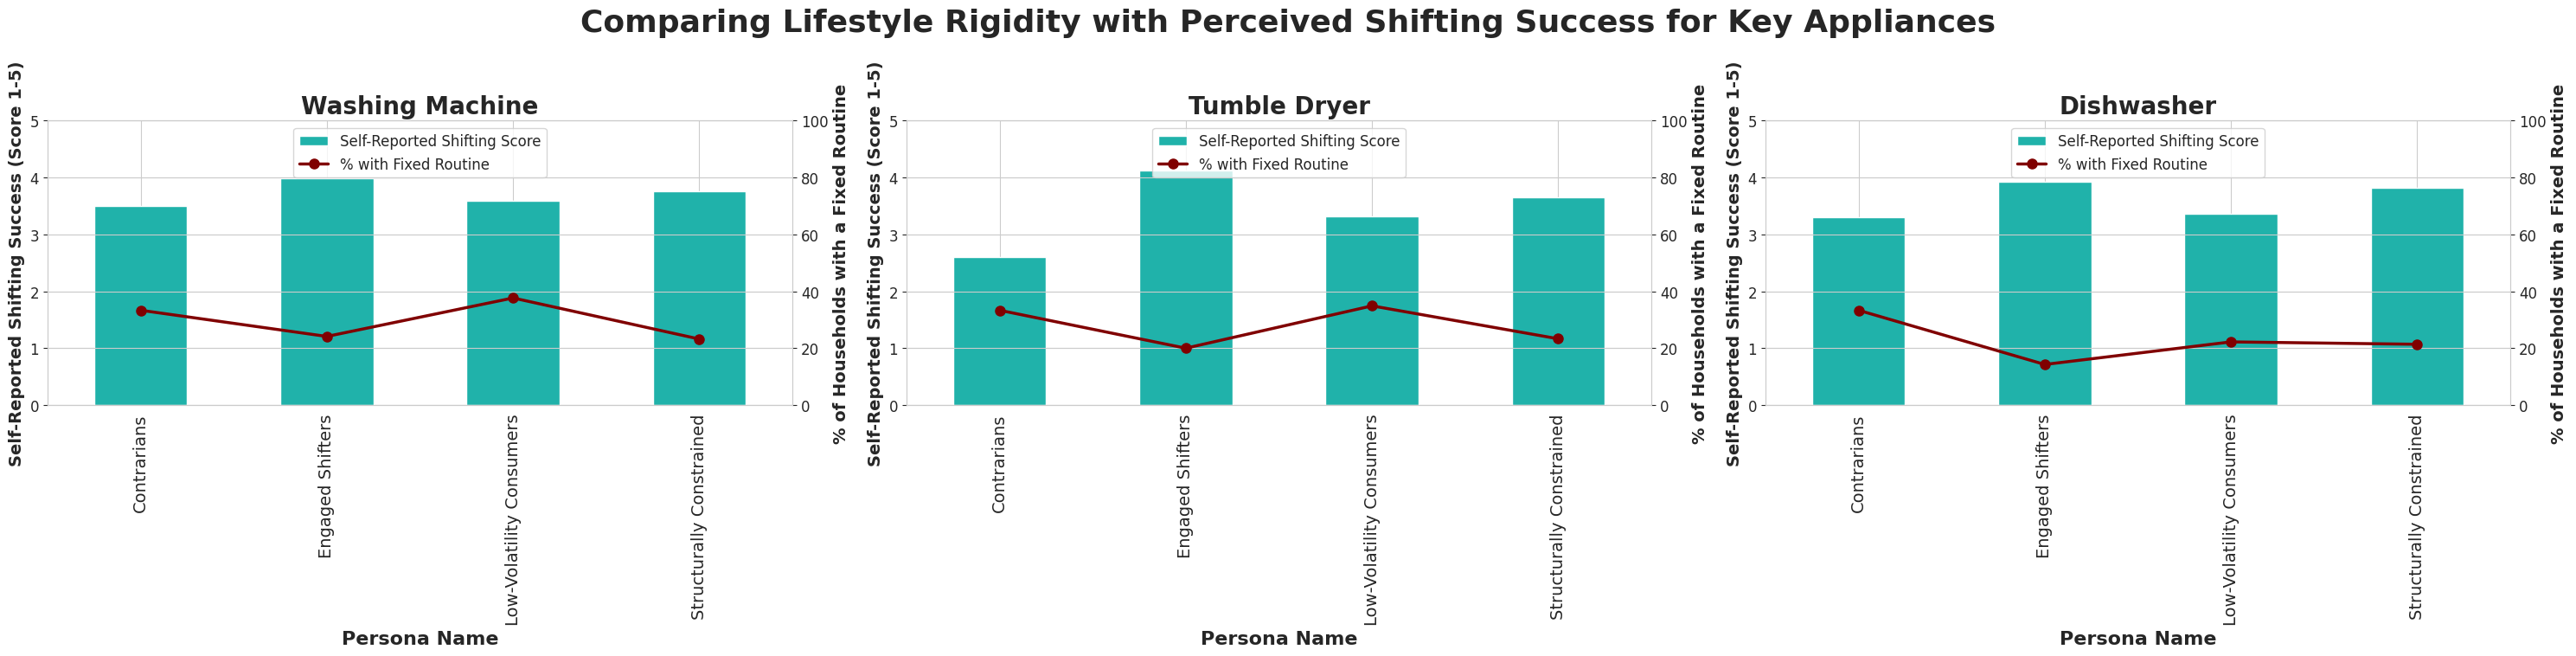

In [14]:
# 4. Appliance routine shifting (e.g. washing machines)
print("\nGenerating Appliance Shifting vs. Routine Rigidity plots...")

appliances = {
    'Washing Machine': ('Self-Reported Shift of Washing Machine', 'Has Fixed Routine for Washing Machine'),
    'Tumble Dryer': ('Self-Reported Shift of Tumble Dryer', 'Has Fixed Routine for Tumble Dryer'),
    'Dishwasher': ('Self-Reported Shift of Dishwasher', 'Has Fixed Routine for Dishwasher')
}

fig, axes = plt.subplots(1, 3, figsize=(30, 8), sharey=False) # Increased figure size for clarity
fig.suptitle('Comparing Lifestyle Rigidity with Perceived Shifting Success for Key Appliances', fontsize=26, weight='bold')

for i, (appliance_name, (shift_col, routine_col)) in enumerate(appliances.items()):
    ax1 = axes[i]

    # Calculate metrics
    shift_data = df.groupby('persona_name')[shift_col].mean().reindex(persona_order)
    routine_data = df.groupby('persona_name')[routine_col].mean().reindex(persona_order) * 100 # as percentage

    # Bar plot for shifting success
    shift_data.plot(kind='bar', ax=ax1, color='lightseagreen', label='Self-Reported Shifting Score', legend=False)
    ax1.set_ylabel('Self-Reported Shifting Success (Score 1-5)', fontsize=14, weight='bold')
    ax1.set_xlabel('Persona Name', weight='bold', fontsize=16)
    ax1.set_title(appliance_name, fontsize=20, weight='bold')
    ax1.tick_params(axis='x', rotation=90, labelsize=14)
    ax1.tick_params(axis='y', labelsize=12)

    # Line plot for routine rigidity on a second y-axis
    ax2 = ax1.twinx()
    routine_data.plot(kind='line', ax=ax2, color='maroon', marker='o', lw=2.5, markersize=8, label='% with Fixed Routine', legend=False)
    ax2.set_ylabel('% of Households with a Fixed Routine', fontsize=14, weight='bold')
    ax2.tick_params(axis='y', labelsize=12)

    # Set y-axis limits
    ax1.set_ylim(0, 5)
    ax2.set_ylim(0, 100)

    # Combine legends from both axes and place it on the plot
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    # Create the combined legend on the second axis
    ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



Generating Overall Barriers and Motivations for the entire LCL Cohort...


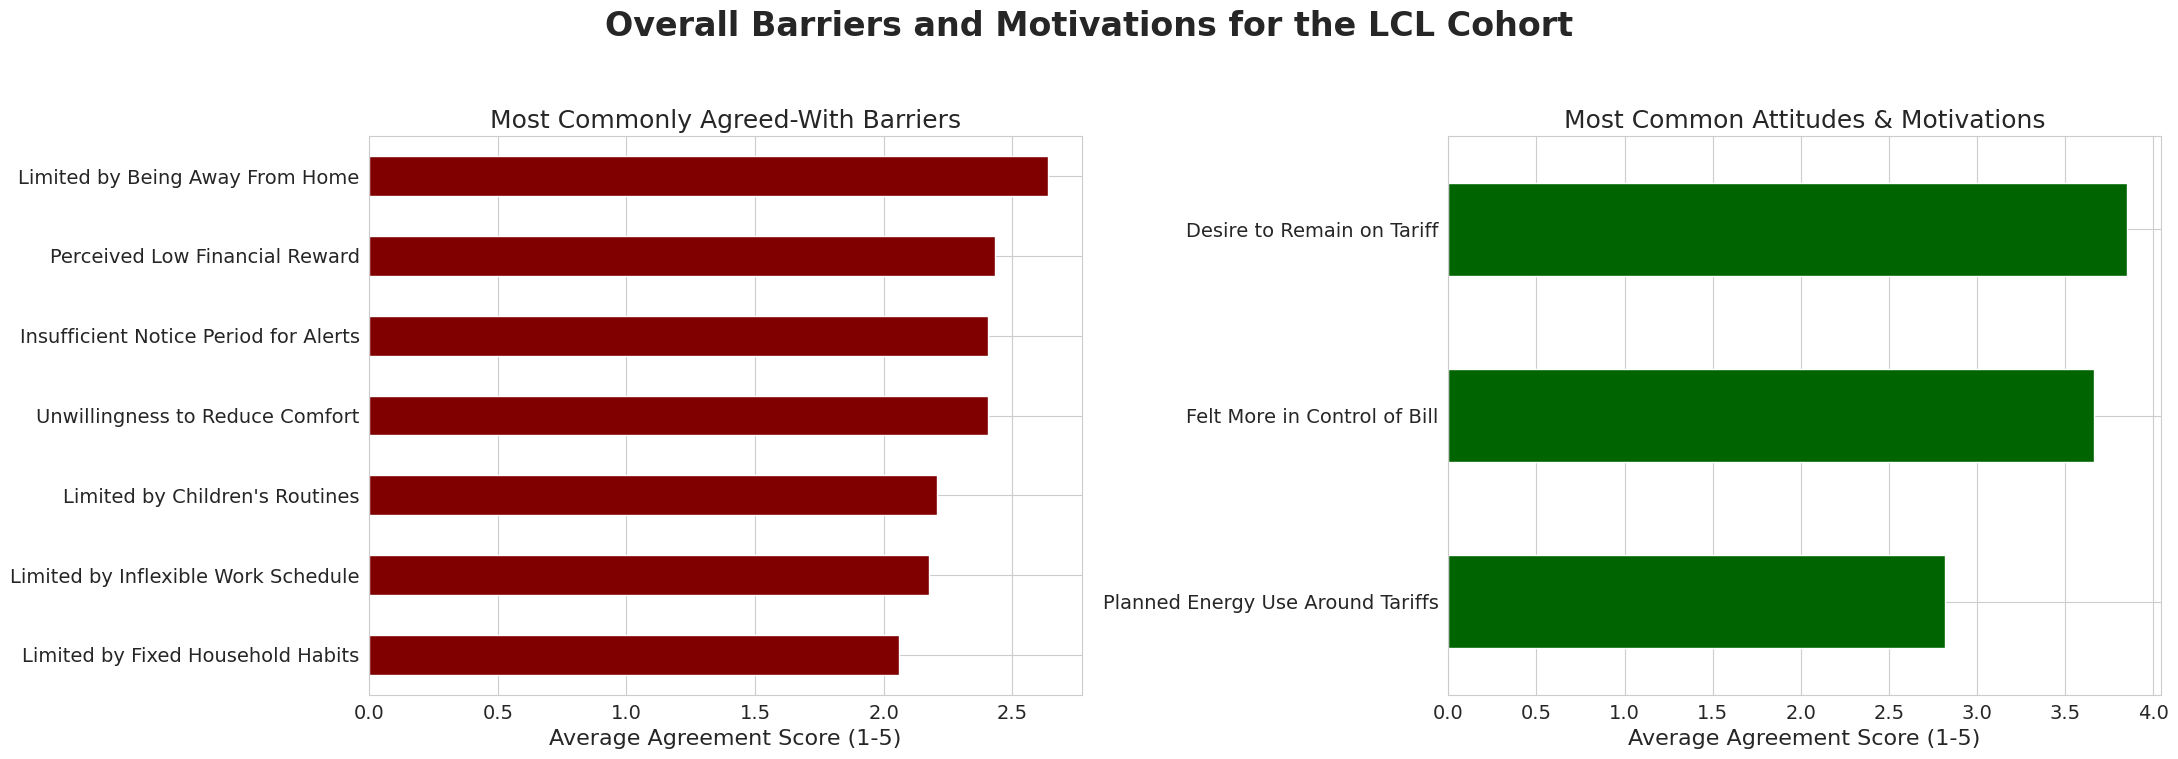

In [15]:
# Barriers and motivations for entire cohort

print("\nGenerating Overall Barriers and Motivations for the entire LCL Cohort...")

all_attitudes = list(positive_factors.keys()) + list(disengagement_factors.keys())
all_barriers = barrier_cols

# Calculate means for the whole dataset
attitude_means = df[all_attitudes].mean().sort_values(ascending=True)
barrier_means = df[all_barriers].mean().sort_values(ascending=True)

# Separate positive and negative attitudes for plotting
positive_attitude_means = df[list(positive_factors.keys())].mean().sort_values(ascending=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle('Overall Barriers and Motivations for the LCL Cohort', fontsize=24, weight='bold')

# Plot Barriers
barrier_means.plot(kind='barh', ax=axes[0], color='maroon')
axes[0].set_title('Most Commonly Agreed-With Barriers', fontsize=18)
axes[0].set_xlabel('Average Agreement Score (1-5)')

# Plot Motivations
positive_attitude_means.plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Most Common Attitudes & Motivations', fontsize=18)
axes[1].set_xlabel('Average Agreement Score (1-5)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 Running final deep dive into specific demographic distributions and ranked reasons 

Generating Demographic Distribution Box Plots


/tmp/ipython-input-171580634.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


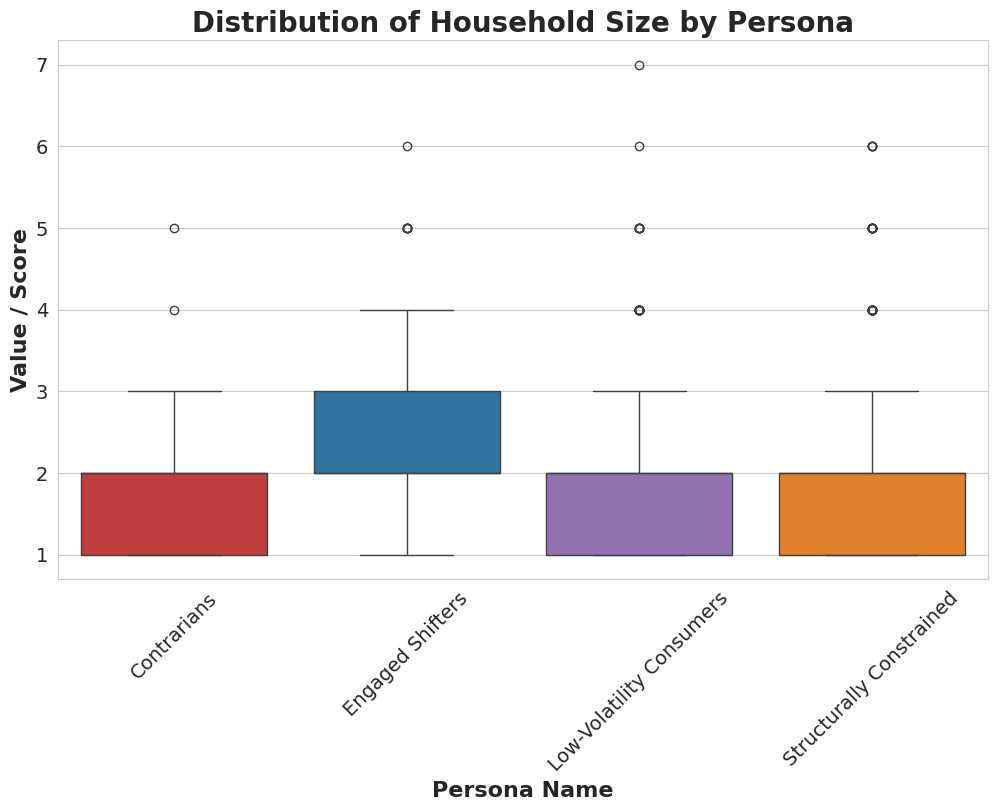

/tmp/ipython-input-171580634.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)


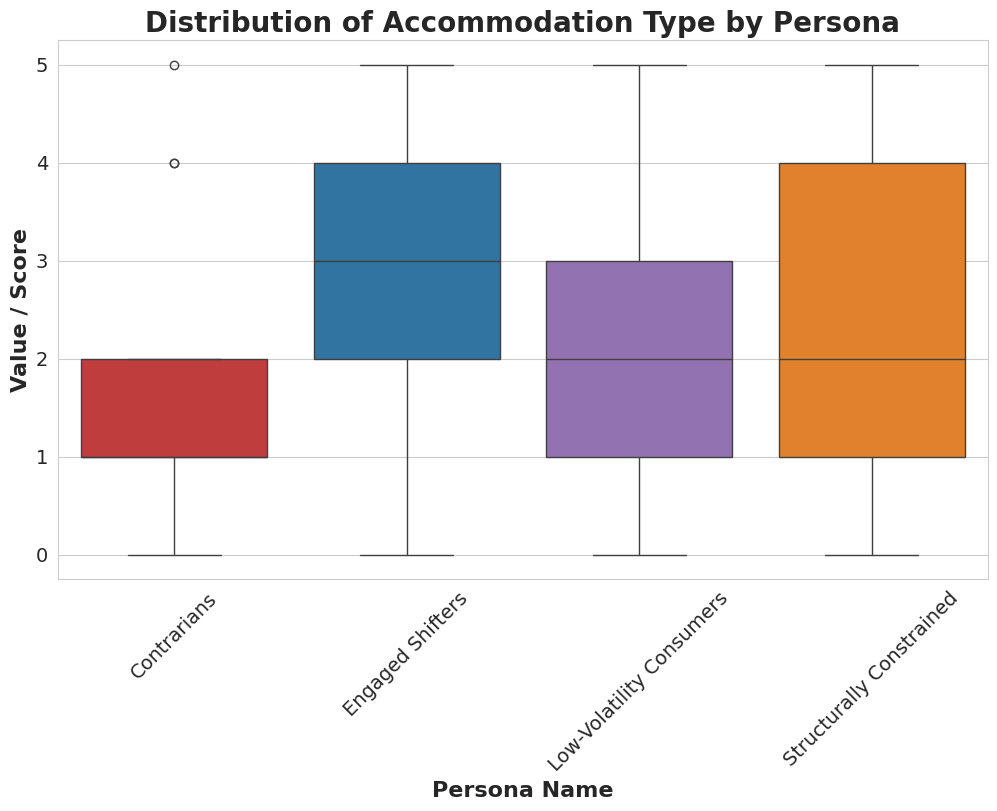


Generating Ranked Barriers and Motivations for each Persona...

DEEP DIVE FOR PERSONA: CONTRARIANS

 Top 3 Agreed-With Barriers 
Insufficient Notice Period for Alerts   3.00
Unwillingness to Reduce Comfort         2.67
Limited by Being Away From Home         2.64

 Top 3 Agreed-With Motivations 
Desire to Remain on Tariff          3.62
Felt More in Control of Bill        2.83
Planned Energy Use Around Tariffs   2.75

DEEP DIVE FOR PERSONA: ENGAGED SHIFTERS

 Top 3 Agreed-With Barriers 
Limited by Being Away From Home       2.52
Perceived Low Financial Reward        2.41
Limited by Inflexible Work Schedule   2.30

 Top 3 Agreed-With Motivations 
Desire to Remain on Tariff          3.88
Felt More in Control of Bill        3.78
Planned Energy Use Around Tariffs   3.12

DEEP DIVE FOR PERSONA: LOW-VOLATILITY CONSUMERS

 Top 3 Agreed-With Barriers 
Insufficient Notice Period for Alerts   2.74
Limited by Being Away From Home         2.63
Unwillingness to Reduce Comfort         2.49

 Top 3 A

In [16]:
# DEEP DIVE into key demographics and ranked reasons for shifting / not

print("\n Running final deep dive into specific demographic distributions and ranked reasons ")

# Demographic box plots
# This shows the full distribution, not just the average.

print("\nGenerating Demographic Distribution Box Plots")

demographic_features_for_boxplot = {
    'Household Size': 'Distribution of Household Size by Persona',
    'Accommodation Type': 'Distribution of Accommodation Type by Persona'
}

for col, title in demographic_features_for_boxplot.items():
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='persona_name', y=col, data=df, palette=persona_colours, order=persona_order)
    plt.title(title, weight='bold')
    plt.xlabel('Persona Name', weight='bold')
    plt.ylabel('Value / Score', weight='bold')
    plt.xticks(rotation=45)
    plt.show()


# Ranked barriers and motivations per persona - easy to read and interpret IF I use in my report
# This directly answers "What was the main reason?" for each group.

print("\nGenerating Ranked Barriers and Motivations for each Persona...")

barrier_cols = [
    'Limited by Being Away From Home', 'Limited by Inflexible Work Schedule',
    "Limited by Children's Routines", 'Limited by Fixed Household Habits',
    'Unwillingness to Reduce Comfort', 'Perceived Low Financial Reward',
    'Insufficient Notice Period for Alerts'
]
motivation_cols = [
    'Felt More in Control of Bill', 'Planned Energy Use Around Tariffs',
    'Desire to Remain on Tariff'
]

for persona in persona_order:
    print(f"\n" + "="*50)
    print(f"DEEP DIVE FOR PERSONA: {persona.upper()}")
    print("="*50)

    # Filter the dataframe for the current persona
    persona_df = df[df['persona_name'] == persona]

    # Calculate and print ranked barriers
    ranked_barriers = persona_df[barrier_cols].mean().sort_values(ascending=False)
    print("\n Top 3 Agreed-With Barriers ")
    print(ranked_barriers.head(3).to_string(float_format='{:.2f}'.format))

    # Calculate and print ranked motivations
    ranked_motivations = persona_df[motivation_cols].mean().sort_values(ascending=False)
    print("\n Top 3 Agreed-With Motivations ")
    print(ranked_motivations.head(3).to_string(float_format='{:.2f}'.format))
